In [20]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
import plotly.express as px
import logging

# Setup logging
logging.basicConfig(filename='data_processing_log.txt', level=logging.INFO, format='%(asctime)s %(message)s')

# Setup Plotly rendering to ensure the plots display in Jupyter Notebooks
import plotly.io as pio
pio.renderers.default = 'notebook'  # For Jupyter Notebooks; use 'browser' for standard Python environment

class GCNGAT(torch.nn.Module):
    def __init__(self):
        super(GCNGAT, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GATConv(16, 16, heads=4, concat=True)
        self.out = torch.nn.Linear(16 * 4, 3)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(self.out(x), dim=1)

def plot_embedding_2d_3d(adata, method, title):
    # Plot 2D or 3D UMAP/PCA/tSNE embeddings
    if '3d' in title.lower():
        df = pd.DataFrame(adata.obsm[method][:, :3], columns=['x', 'y', 'z'])
        fig = px.scatter_3d(df, x='x', y='y', z='z', color=adata.obs['cell_type'].astype(str), title=f'{title}')
    else:
        df = pd.DataFrame(adata.obsm[method][:, :2], columns=['x', 'y'])
        fig = px.scatter(df, x='x', y='y', color=adata.obs['cell_type'].astype(str), title=f'{title}')
    
    fig.update_traces(marker=dict(size=5, line=dict(width=1, color='DarkSlateGrey')))
    fig.show()  # Ensure the figure is displayed explicitly

# Load data
adata = sc.read_csv('data.csv')

# Preprocess and quality control
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Feature selection
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable].copy()

# Dimensionality reduction
sc.tl.pca(adata, svd_solver='arpack', n_comps=3)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=3)
sc.tl.umap(adata, n_components=3)
sc.tl.tsne(adata, n_pcs=3)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(adata.obsm['X_pca'])
adata.obs['cell_type'] = pd.Categorical(kmeans.labels_)
silhouette_avg = silhouette_score(adata.obsm['X_pca'], adata.obs['cell_type'].cat.codes)
logging.info(f"Clustering Silhouette Score: {silhouette_avg}")

# Graph Neural Network setup
features = torch.tensor(adata.X, dtype=torch.float)
edge_index = torch.tensor(np.array(adata.obsp['connectivities'].nonzero()), dtype=torch.long)
data = Data(x=features, edge_index=edge_index)
data.y = torch.tensor(adata.obs['cell_type'].cat.codes, dtype=torch.long)

# Define masks for training and validation
num_nodes = data.y.shape[0]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
num_train = int(num_nodes * 0.8)
train_indices = torch.randperm(num_nodes)[:num_train]
val_indices = torch.randperm(num_nodes)[num_train:]
train_mask[train_indices] = True
val_mask[val_indices] = True
data.train_mask = train_mask
data.val_mask = val_mask

# Training setup
model = GCNGAT()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions = out.argmax(dim=1)
        valid_acc = accuracy_score(data.y[data.val_mask].numpy(), predictions[data.val_mask].numpy())
        logging.info(f'Epoch {epoch}: Validation Accuracy: {valid_acc}')

# Visualization of results
plot_embedding_2d_3d(adata, 'X_pca', 'PCA 3D')
plot_embedding_2d_3d(adata, 'X_pca', 'PCA 2D')
plot_embedding_2d_3d(adata, 'X_tsne', 't-SNE 2D')
plot_embedding_2d_3d(adata, 'X_umap', 'UMAP 3D')
plot_embedding_2d_3d(adata, 'X_umap', 'UMAP 2D')


filtered out 16215 cells that have less than 200 genes expressed
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=3
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 3
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)
computing tSNE
    using 'X_pca' with n_pcs = 3
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:00:49)


filtered out 16215 cells that have less than 200 genes expressed
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:01:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:10)


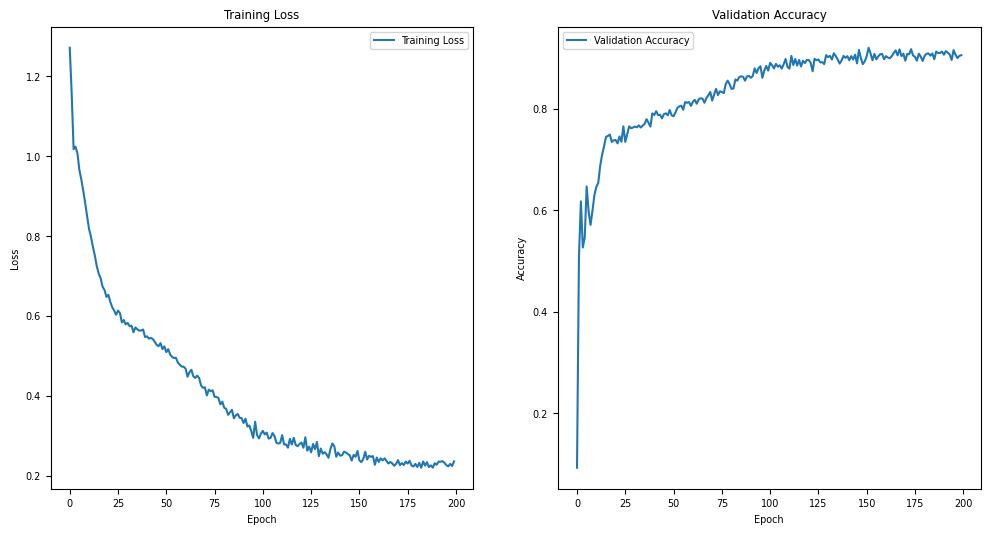

In [21]:
import scanpy as sc
import numpy as np
import plotly.express as px
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging
import plotly.express as px

def plot_embedding(data, labels, title):
    fig = px.scatter(
        data, 
        x='x', 
        y='y', 
        color=labels.astype(str),
        title=title,
        labels={'color': 'Cell Type'}
    )
    fig.update_traces(marker=dict(size=5, line=dict(width=1, color='DarkSlateGrey')))
    fig.show()


# Setup logging
logging.basicConfig(filename='data_processing_log.txt', level=logging.INFO, format='%(asctime)s %(message)s')

# Load data
logging.info("Loading data")
adata = sc.read_csv('data.csv')
logging.info(f"Data loaded with shape {adata.shape}")

# Quality control
logging.info("Starting quality control")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
logging.info("Quality control completed")

# Normalization
logging.info("Normalizing data")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
logging.info("Normalization completed")

# Feature Selection
logging.info("Starting feature selection")
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable].copy()
logging.info("Feature selection completed")

# Dimensionality Reduction
logging.info("Starting dimensionality reduction")
sc.tl.pca(adata, svd_solver='arpack')
sc.tl.tsne(adata, n_pcs=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
logging.info("Dimensionality reduction completed")

# Generate synthetic cell types using K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(adata.obsm['X_pca'])
adata.obs['cell_type'] = kmeans.labels_.astype(str)
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
silhouette_avg = silhouette_score(adata.obsm['X_pca'], adata.obs['cell_type'].cat.codes)
logging.info(f"Synthetic cell type labels generated using K-means clustering, silhouette score: {silhouette_avg}")

# Graph Neural Network setup
features = torch.tensor(adata.X, dtype=torch.float)
edge_index = torch.tensor(np.array(adata.obsp['connectivities'].nonzero()), dtype=torch.long)
data = Data(x=features, edge_index=edge_index)
data.y = torch.tensor(adata.obs['cell_type'].cat.codes, dtype=torch.long)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, len(np.unique(kmeans.labels_)))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Prepare for training and evaluation
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
losses = []
accuracies = []

# Split data for training and validation
train_mask = np.random.rand(len(data.y)) < 0.8
val_mask = ~train_mask

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        pred = out[val_mask].max(1)[1]
        acc = accuracy_score(data.y[val_mask].numpy(), pred.numpy())
        accuracies.append(acc)
    logging.info(f'Epoch: {epoch}, Training Loss: {loss.item()}, Validation Accuracy: {acc}')

# Plot training loss and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot PCA, t-SNE, UMAP
pca_df = pd.DataFrame(adata.obsm['X_pca'][:, :2], columns=['x', 'y'])
tsne_df = pd.DataFrame(adata.obsm['X_tsne'], columns=['x', 'y'])
umap_df = pd.DataFrame(adata.obsm['X_umap'], columns=['x', 'y'])
plot_embedding(pca_df, adata.obs['cell_type'].cat.codes, 'PCA')
plot_embedding(tsne_df, adata.obs['cell_type'].cat.codes, 't-SNE')
plot_embedding(umap_df, adata.obs['cell_type'].cat.codes, 'UMAP')

# Save final results
adata.write('processed_data_GCN.h5ad')
logging.info("All processing steps completed and data saved")


In [22]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import logging

# Setup logging
logging.basicConfig(filename='data_processing_log.txt', level=logging.INFO, format='%(asctime)s %(message)s')

class GATModel(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GATModel, self).__init__()
        self.gat1 = GATConv(num_features, 8, heads=8, concat=True)
        self.gat2 = GATConv(8 * 8, num_classes, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

def plot_embedding(data, labels, title, dimensions='2d'):
    if dimensions == '3d':
        fig = px.scatter_3d(data, x='x', y='y', z='z', color=labels.astype(str), title=title)
    else:
        fig = px.scatter(data, x='x', y='y', color=labels.astype(str), title=title)
    fig.update_traces(marker=dict(size=5, line=dict(width=1, color='DarkSlateGrey')))
    fig.show()

# Load and preprocess data
adata = sc.read_csv('data.csv')
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Feature selection and dimensionality reduction
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable].copy()
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca')

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(adata.obsm['X_pca'])
adata.obs['cell_type'] = pd.Categorical(kmeans.labels_)
silhouette_avg = silhouette_score(adata.obsm['X_pca'], adata.obs['cell_type'].cat.codes)
logging.info(f"Clustering completed with silhouette score: {silhouette_avg}")

# Setup graph data
features = torch.tensor(adata.X, dtype=torch.float)
edge_index = torch.tensor(np.array(adata.obsp['connectivities'].nonzero()), dtype=torch.long)
data = Data(x=features, edge_index=edge_index)
data.y = torch.tensor(adata.obs['cell_type'].cat.codes, dtype=torch.long)

# Initialize model
model = GATModel(features.shape[1], len(np.unique(data.y.numpy())))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Train model
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    logging.info(f'Epoch {epoch}: Loss {loss.item()}')

# Visualization of embeddings
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).detach().numpy()

# Apply PCA, t-SNE, and UMAP on the embeddings for visualization
embeddings_adata = sc.AnnData(embeddings)
if embeddings.shape[0] > 2:
    sc.pp.neighbors(embeddings_adata, n_neighbors=min(15, embeddings.shape[0] - 1))
    sc.tl.pca(embeddings_adata, n_comps=min(min(embeddings.shape[0], embeddings.shape[1], 3), 2))
    sc.tl.tsne(embeddings_adata, n_pcs=min(min(embeddings.shape[0], embeddings.shape[1], 3), 2))
    sc.tl.umap(embeddings_adata, n_components=min(min(embeddings.shape[0], embeddings.shape[1], 3), 2))

    plot_embedding(pd.DataFrame(embeddings_adata.obsm['X_pca'], columns=['x', 'y']), adata.obs['cell_type'].cat.codes, 'GAT Embedded 2D PCA')
    plot_embedding(pd.DataFrame(embeddings_adata.obsm['X_tsne'], columns=['x', 'y']), adata.obs['cell_type'].cat.codes, 'GAT Embedded 2D t-SNE')
    plot_embedding(pd.DataFrame(embeddings_adata.obsm['X_umap'], columns=['x', 'y']), adata.obs['cell_type'].cat.codes, 'GAT Embedded 2D UMAP')
else:
    logging.warning("Not enough samples to compute neighbors and perform UMAP.")

# Save results
adata.write('processed_data_with_gat.h5ad')
logging.info("All processing steps completed and data saved")


filtered out 16215 cells that have less than 200 genes expressed
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing PCA
    with n_comps=2
    finished (0:00:00)
computing tSNE
    using data matrix X directly
    using sklearn.manifold.TSNE
    finished: added
    '